In [ ]:
# bin and campaign consatnt and we want to see which merchant is performing best under these constants.
#bin and gateway constant and which campaign performs best.

In [1]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Your credentials
username = "soundDev"
password = "e1kemyOwhAYXNidM"
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"
database_name = "checkoutETL"
collection_name = "transactions"

# URL encode username and password in case of special chars
username = urllib.parse.quote_plus(username)
password = urllib.parse.quote_plus(password)

# Build the MongoDB connection string (note: mongodb:// not mongodb+srv://)
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/{database_name}"
    "?ssl=true&authSource=admin"
)

# Connect to MongoDB
client = MongoClient(mongo_uri)

# Select DB and collection
db = client[database_name]
collection = db[collection_name]

# Load data into DataFrame (limit to 1000 documents to avoid overload)
df = pd.DataFrame(list(collection.find()))

# Show first rows
print(df.head())


                        _id  transactionId 3DTxnResult  __v achBankName  \
0  6816c18f10f783ceceb640ab         438514       false    0        None   
1  6816c18f10f783ceceb640b5         438526       false    0        None   
2  6816c18f10f783ceceb640c6         438550       false    0        None   
3  6816c18f10f783ceceb640c8         438554       false    0        None   
4  6816c18f10f783ceceb640d0         438567       false    0        None   

   actualOrderId affId authCode avsResponse  billingCycleNumber  ...  \
0         292141  None   196536        None                 2.0  ...   
1         292151  None     None        None                 6.0  ...   
2         292165  None   09109E           Y                 1.0  ...   
3         292169  None   02230E           W                 1.0  ...   
4         292178  None   018655           U                 3.0  ...   

  sourceValue2 sourceValue3 sourceValue4 sourceValue5  state  surcharge  \
0         None         None         None 

In [6]:
# Filter out necessary columns
df = df[['campaignName', 'merchant', 'cardBin', 'transactionId', 'responseType']]

# Drop nulls if any
df = df.dropna()

# Remove duplicates if any
df = df.drop_duplicates(subset='transactionId')

# Create Success Flag
df['is_success'] = df['responseType'].eq('SUCCESS').astype(int)


In [7]:
df.shape

(122503, 6)

In [16]:
# BIN + CAMPAIGN COMBO → BEST MERCHANTS

In [12]:
# Group by bin + campaign + merchant
g1 = df.groupby(['cardBin', 'campaignName', 'merchant']).agg(
    total_txns=('transactionId', 'count'),
    success_count=('is_success', 'sum')
).reset_index()

# Filter combos with at least 50 txns and 20 successes
g1_filtered = g1[(g1['total_txns'] > 50) & (g1['success_count'] > 20)]

# Get top BIN + campaign combinations
top_bin_campaign = (
    g1_filtered.groupby(['cardBin', 'campaignName'])['total_txns']
    .sum().nlargest(10).reset_index()[['cardBin', 'campaignName']]
)

# Merge to filter only top combos
q1_result = pd.merge(top_bin_campaign, g1_filtered, on=['cardBin', 'campaignName'])

# Add success rate
q1_result['success_rate'] = q1_result['success_count'] / q1_result['total_txns']
q1_result = q1_result.sort_values(['cardBin', 'campaignName', 'success_rate'], ascending=[True, True, False])


In [13]:
q1_result

,cardBin,campaignName,merchant,total_txns,success_count,success_rate
0,410039,OptiFuel,EMS Josh (NMI),194,173,0.891753
4,410039,OptiFuel,Quantum (NMI),209,186,0.889952
1,410039,OptiFuel,NMI (EMS),68,59,0.867647
2,410039,OptiFuel,Payarc Josh (NMI),280,241,0.860714
5,410039,OptiFuel,Seamless Chex (Auth.net),122,94,0.770492
3,410039,OptiFuel,Phoenix (NMI),111,75,0.675676
33,426684,OptiFuel,EMS Josh (NMI),132,70,0.530303
35,426684,OptiFuel,Phoenix (NMI),54,23,0.425926
36,426684,OptiFuel,Quantum (NMI),71,30,0.422535
34,426684,OptiFuel,Payarc Josh (NMI),127,36,0.283465


In [17]:
#BIN + MERCHANT COMBO → BEST CAMPAIGNS

In [20]:
# Group by bin + merchant + campaign
g2 = df.groupby(['cardBin', 'merchant', 'campaignName']).agg(
    total_txns=('transactionId', 'count'),
    success_count=('is_success', 'sum')
).reset_index()

# Filter combos with at least 50 txns and 20 successes
g2_filtered = g2[(g2['total_txns'] > 50) & (g2['success_count'] > 20)]

# Get top BIN + merchant combinations
top_bin_merchant = (
    g2_filtered.groupby(['cardBin', 'merchant'])['total_txns']
    .sum().nlargest(15).reset_index()[['cardBin', 'merchant']]
)

# Merge to filter only top combos
q2_result = pd.merge(top_bin_merchant, g2_filtered, on=['cardBin', 'merchant'])

# Add success rate
q2_result['success_rate'] = q2_result['success_count'] / q2_result['total_txns']
q2_result = q2_result.sort_values(['cardBin', 'merchant', 'success_rate'], ascending=[True, True, False])


In [21]:
q2_result

,cardBin,merchant,campaignName,total_txns,success_count,success_rate
6,410039,EMS Josh (NMI),MozzGuard,74,66,0.891892
7,410039,EMS Josh (NMI),OptiFuel,194,173,0.891753
5,410039,EMS Josh (NMI),BTE Hearing CIC Pro (Native) Original,139,121,0.870504
22,410039,Payarc Josh (NMI),OptiFuel,280,241,0.860714
12,410039,Quantum (NMI),BTE Hearing CIC Pro (Native) Original,89,82,0.921348
13,410039,Quantum (NMI),OptiFuel,209,186,0.889952
11,410039,Quantum (NMI),BTE Hearing CIC Pro (Facebook),70,60,0.857143
2,410039,Seamless Chex (Auth.net),MozzGuard,105,103,0.980952
4,410039,Seamless Chex (Auth.net),Ozzi Heat,196,157,0.801020
3,410039,Seamless Chex (Auth.net),OptiFuel,122,94,0.770492


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Encode categorical columns
df_ml = df.copy()
for col in ['merchant', 'campaignName', 'cardBin']:
    df_ml[col] = LabelEncoder().fit_transform(df_ml[col])

# Prepare X and y
X = df_ml[['merchant', 'campaignName', 'cardBin']]
y = df_ml['is_success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit a simple tree model
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.49      0.54     14481
           1       0.61      0.72      0.66     16145

    accuracy                           0.61     30626
   macro avg       0.61      0.60      0.60     30626
weighted avg       0.61      0.61      0.60     30626



In [23]:
q1_result

,cardBin,campaignName,merchant,total_txns,success_count,success_rate
0,410039,OptiFuel,EMS Josh (NMI),194,173,0.891753
4,410039,OptiFuel,Quantum (NMI),209,186,0.889952
1,410039,OptiFuel,NMI (EMS),68,59,0.867647
2,410039,OptiFuel,Payarc Josh (NMI),280,241,0.860714
5,410039,OptiFuel,Seamless Chex (Auth.net),122,94,0.770492
3,410039,OptiFuel,Phoenix (NMI),111,75,0.675676
33,426684,OptiFuel,EMS Josh (NMI),132,70,0.530303
35,426684,OptiFuel,Phoenix (NMI),54,23,0.425926
36,426684,OptiFuel,Quantum (NMI),71,30,0.422535
34,426684,OptiFuel,Payarc Josh (NMI),127,36,0.283465


In [24]:
q2_result

,cardBin,merchant,campaignName,total_txns,success_count,success_rate
6,410039,EMS Josh (NMI),MozzGuard,74,66,0.891892
7,410039,EMS Josh (NMI),OptiFuel,194,173,0.891753
5,410039,EMS Josh (NMI),BTE Hearing CIC Pro (Native) Original,139,121,0.870504
22,410039,Payarc Josh (NMI),OptiFuel,280,241,0.860714
12,410039,Quantum (NMI),BTE Hearing CIC Pro (Native) Original,89,82,0.921348
13,410039,Quantum (NMI),OptiFuel,209,186,0.889952
11,410039,Quantum (NMI),BTE Hearing CIC Pro (Facebook),70,60,0.857143
2,410039,Seamless Chex (Auth.net),MozzGuard,105,103,0.980952
4,410039,Seamless Chex (Auth.net),Ozzi Heat,196,157,0.801020
3,410039,Seamless Chex (Auth.net),OptiFuel,122,94,0.770492


In [25]:
df['merchant'].value_counts()


merchant
Seamless Chex (Auth.net)                    25949
Payarc Josh (NMI)                           15740
EMS Josh (NMI)                              15679
Adyen US                                    14999
Quantum (NMI)                               14111
ADYEN AU                                    13994
Stripe (Josh)                                7653
Phoenix (NMI)                                4893
NMI (EMS)                                    4748
Finix Josh (Auth.net)                        1306
Airwallex (AU)                               1012
Paypal US                                     814
Quantum PremHealth (NMI)                      449
Airwallex (HK)                                291
FlexPayPlugin - Seamless Chex (Auth.net)      279
FlexPayPlugin - Quantum (NMI)                 196
FlexPayPlugin - Payarc Josh (NMI)             120
PayPal@OM                                     111
FlexPayPlugin - EMS Josh (NMI)                 61
Auth.net (EMS)                           

In [26]:
df['campaignName'].value_counts()


campaignName
OptiFuel                                 34581
BTE Hearing CIC Pro (Native) Original    12424
MozzGuard                                11231
BTE Hearing CIC Pro (Native) - UK        10338
BTE Hearing CIC Pro (Facebook)            9717
                                         ...  
BTE Hearing CIC Pro (Native) - FR            4
BTE Hearing CIC Pro - YT - AU                3
HeatX                                        2
Sole Cleanse                                 2
Mozz Guard Camp (CA)                         1
Name: count, Length: 65, dtype: int64

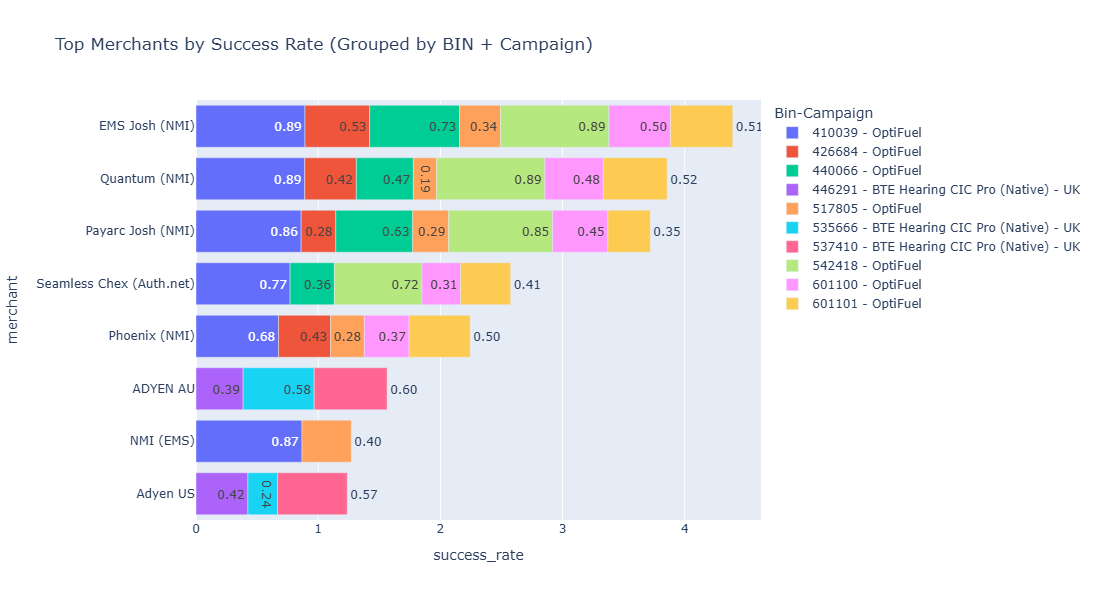

In [31]:
import plotly.express as px

q1_result['Bin-Campaign'] = q1_result['cardBin'].astype(str) + ' - ' + q1_result['campaignName']

fig = px.bar(
    q1_result,
    x='success_rate',
    y='merchant',
    color='Bin-Campaign',
    text='success_rate',
    orientation='h',
    title='Top Merchants by Success Rate (Grouped by BIN + Campaign)',
    hover_data=['cardBin', 'campaignName', 'total_txns', 'success_count']
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig.show()


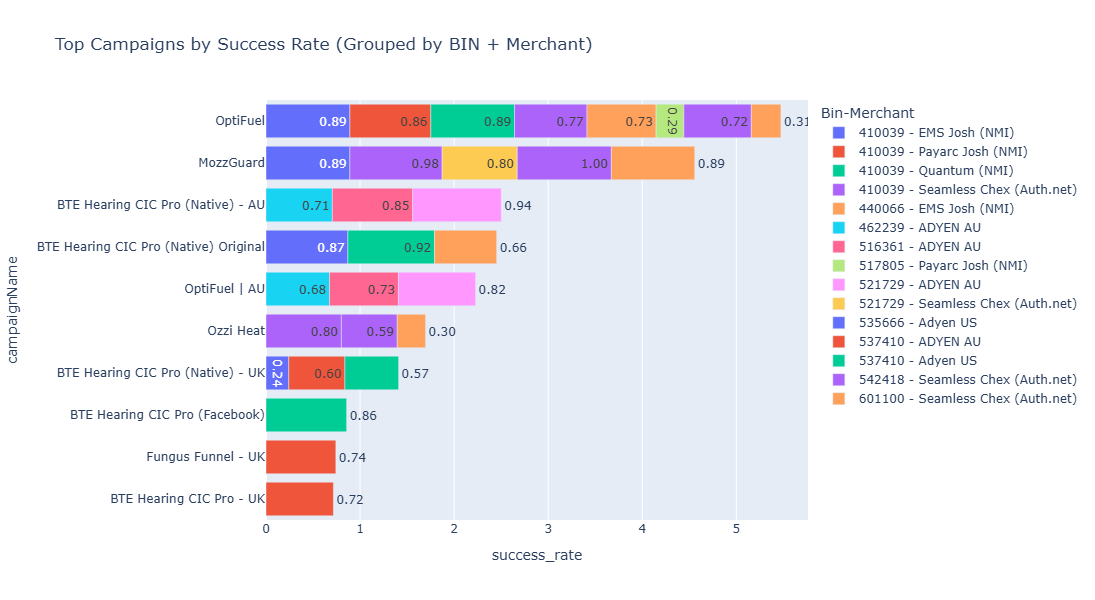

In [38]:
q2_result['Bin-Merchant'] = q2_result['cardBin'].astype(str) + ' - ' + q2_result['merchant']

fig = px.bar(
    q2_result,
    x='success_rate',
    y='campaignName',
    color='Bin-Merchant',
    text='success_rate',
    orientation='h',
    title='Top Campaigns by Success Rate (Grouped by BIN + Merchant)',
    hover_data=['cardBin', 'merchant', 'total_txns', 'success_count']
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig.show()



In [33]:
q1_result.to_csv('q1_result.csv', index=False)

In [34]:
q2_result.to_csv('q2_result.csv', index=False)

In [35]:
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/65.9 MB 3.0 MB/s eta 0:00:22
   - -------------------------------------- 1.8/65.9 MB 3.6 MB/s eta 0:00:18
   - -------------------------------------- 2.6/65.9 MB 3.9 MB/s eta 0:00:17
   -- ------------------------------------- 3.7/65.9 MB 4.1 MB/s eta 0:00:16
   --- ------------------------------------ 5.2/65.9 MB 4.7 MB/s eta 0:00:13
   ---- ----------------------------------- 7.1/65.9 MB 5.3 MB/s eta 0:00:12
   ----- ---------------------------------- 8.7/65.9 MB 5.9 MB/s eta 0:00:10
   ----- ---------------------------------- 9.7/65.9 MB 5.6 MB/s eta 0:00:10
   ------ --------------------------------- 10.2/65.9 MB 5.4 MB/s eta 0:00:11
   ------ --------------------------------- 11.0/65.9 MB 5.1 MB/s eta 0:00:11
   ------ 